In [136]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [137]:
#한글 깨짐 방지
from matplotlib import rc, font_manager
font_path='data/fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)
#마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus']=False

In [96]:
temperature207=pd.read_csv('./data/temperature/207정선_월별.csv')
temperature208=pd.read_csv('./data/temperature/208정선_월별.csv',encoding='cp949')
mackerel=pd.read_csv('./data/mackerel/부산_고등어_생산량(선어).csv',encoding='cp949')

df=pd.merge(temperature207,mackerel,on=['년도','월'])
# df.to_csv('data/merge/207_mackerel_product.csv',index=False,encoding='utf-8-sig')
df=pd.merge(temperature208,mackerel,on=['년도','월'])
# df.to_csv('data/merge/208_mackerel_product.csv',index=False,encoding='utf-8-sig')

In [192]:
merge_207=pd.read_csv('./data/merge/207_mackerel_product.csv',encoding='cp949')

# '%Y-%m' 형식으로 변환
merge_207['date'] = pd.to_datetime(merge_207['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
merge_207.set_index('date', inplace=True)

merge_207=merge_207[['수온','염분','용존산소','생산량']]
merge_207.info()
merge_207

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2008-01-01 to 2022-12-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   수온      180 non-null    float64
 1   염분      180 non-null    float64
 2   용존산소    180 non-null    float64
 3   생산량     180 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 7.0 KB


,수온,염분,용존산소,생산량
date,,,,
2008-01-01,15.75,33.650,5.51500,7994
2008-02-01,14.80,34.010,5.82000,1430
2008-03-01,14.30,33.985,5.73500,3001
2008-04-01,13.80,33.960,5.65000,1385
2008-05-01,14.35,34.070,5.23500,582
...,...,...,...,...
2022-08-01,20.00,32.820,3.97140,3900
2022-09-01,21.35,33.425,4.41425,5494
2022-10-01,22.70,34.030,4.85710,5339


In [193]:
seq_length=3 # 3~7사이 값 설정
train_size = int(len(merge_207)*0.90)
train_set=merge_207[0:train_size]
test_set=merge_207[train_size-seq_length:]
print(train_set.shape,test_set.shape)


(162, 4) (21, 4)


In [194]:
train_set.head()


,수온,염분,용존산소,생산량
date,,,,
2008-01-01,15.75,33.650,5.515,7994
2008-02-01,14.80,34.010,5.820,1430
2008-03-01,14.30,33.985,5.735,3001
2008-04-01,13.80,33.960,5.650,1385
2008-05-01,14.35,34.070,5.235,582


In [195]:
#input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:, :-1])

# output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])
train_set.iloc[:, -1]=scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:, -1]=scaler_y.transform(test_set.iloc[:,[-1]])

In [196]:
test_set[:]

,수온,염분,용존산소,생산량
date,,,,
2021-04-01,-0.825777,-10.676201,-1.169752,0.051640
2021-05-01,-0.823645,-10.697753,-1.160281,0.001904
2021-06-01,-0.821514,-10.719304,-1.150811,0.003699
2021-07-01,0.481752,0.570934,0.330924,0.056521
2021-08-01,0.518248,0.290657,-0.012455,0.127052
2021-09-01,0.678832,0.486159,0.143619,0.297469
2021-10-01,0.839416,0.681661,0.299694,0.250558
2021-11-01,0.620438,0.747405,0.382949,0.355567
2021-12-01,0.401460,0.813149,0.466203,0.584826


In [197]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import numpy as np

In [198]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [199]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        y_=time_series[i+seq_length,[2]]
        dataX.append(x_)
        dataY.append(y_)
    return np.array(dataX), np.array(dataY)

In [200]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set),seq_length)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(159, 3, 4) (159, 1)
(18, 3, 4) (18, 1)


In [201]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)
testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

print(trainX_tensor.size(), trainY_tensor.size())
print(testX_tensor.size(), testY_tensor.size())

torch.Size([159, 3, 4]) torch.Size([159, 1])
torch.Size([18, 3, 4]) torch.Size([18, 1])


In [202]:
train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_loader=DataLoader(train_dataset, shuffle=True,
                        drop_last=True)

In [203]:
# 수정 필요

data_dim=4
hidden_dim=8
output_dim=1
learning_late=0.01
epochs=1000

In [204]:
class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim=hidden_dim
    self.seq_length=seq_length
    self.output_dim=output_dim
    self.layers=layers

    self.lstm=nn.LSTM(input_dim, 
                      hidden_dim, 
                      num_layers=layers,
                      batch_first=True)
    
    self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

  def reset_hidden_state(self):
    self.hidden=(
      torch.zeros(self.layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.layers, self.seq_length, self.hidden_dim)
    )
  def forward(self, x):
    x, _status=self.lstm(x)
    x=self.fc(x[:, -1])
    return x

In [205]:
def train_model(model, train_df, epochs=None, lr=None, verbos=10, patience=10):
  criterion=nn.MSELoss().to(device)
  optimizer=optim.Adam(model.parameters(), lr=learning_late)
  n_epochs=epochs

  train_hist=np.zeros(n_epochs)
  for epoch in range(n_epochs):
    avg_cost=0
    total_batch=len(train_df)

    for batch_idxm, sample in enumerate(train_df):
      x_train, y_train=sample
      model.reset_hidden_state()
      output=model(x_train)
      loss=criterion(output, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_cost+=loss/total_batch
    
    train_hist[epoch]=avg_cost

    if epoch % verbos==0:
      print('Epoch:{}, train_loss:{}'.format(epoch, avg_cost.item()))

    if(epoch % patience==0) & (epoch!=0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print("Early Stopping")
        break
  return model.eval(), train_hist

# best loss / model 추가

In [206]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist=train_model(net, train_loader, epochs=epochs,
                              lr=learning_late, verbos=20, patience=100)

Epoch:0, train_loss:0.07633904367685318
Epoch:20, train_loss:0.029363298788666725
Epoch:40, train_loss:0.02894134260714054
Epoch:60, train_loss:0.026643387973308563
Epoch:80, train_loss:0.027230430394411087
Epoch:100, train_loss:0.025850169360637665
Epoch:120, train_loss:0.022313574329018593
Epoch:140, train_loss:0.015675807371735573
Epoch:160, train_loss:0.022876078262925148
Epoch:180, train_loss:0.020331554114818573
Epoch:200, train_loss:0.005977799650281668
Epoch:220, train_loss:0.005480966530740261
Epoch:240, train_loss:0.0036888171453028917
Epoch:260, train_loss:0.003615656867623329
Epoch:280, train_loss:0.018355168402194977
Epoch:300, train_loss:0.00311302556656301
Epoch:320, train_loss:0.0028020599856972694
Epoch:340, train_loss:0.0022890171967446804
Epoch:360, train_loss:0.032787106931209564
Epoch:380, train_loss:0.002601020270958543
Epoch:400, train_loss:0.0031893306877464056
Early Stopping


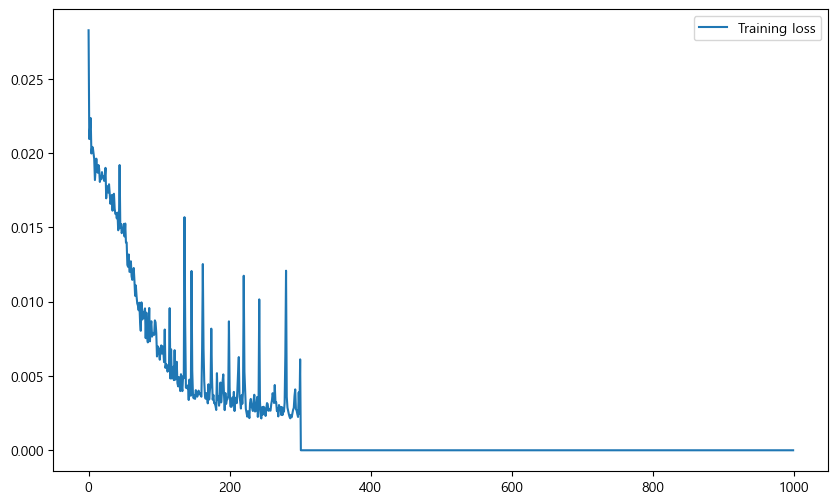

In [170]:
fig=plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training loss')
plt.legend()
plt.show()

In [183]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAe SCORE:', MAE(pred_inverse, testY_inverse))

MAe SCORE: 6277.666042166633


In [188]:
date=['2021-07',
               '2021-08', '2021-09', '2021-10', '2021-11',
               '2021-12', '2022-01', '2022-02', '2022-03',
               '2022-04', '2022-05', '2022-06', '2022-07',
               '2022-08', '2022-09', '2022-10', '2022-11',
               '2022-12']

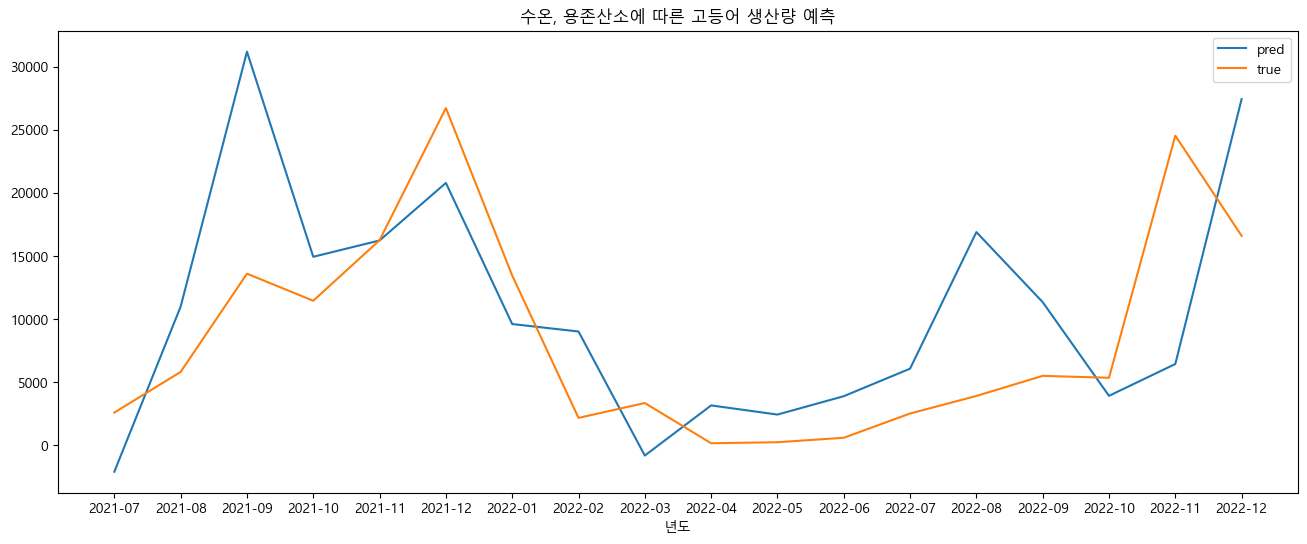

In [191]:
fig=plt.figure(figsize=(16,6))
plt.title('수온, 용존산소에 따른 고등어 생산량 예측')
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
plt.xlabel('년도')

plt.xticks(np.arange(len(pred_inverse)),date)
plt.legend()
plt.show()

In [190]:
test_set.index

DatetimeIndex(['2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01'],
              dtype='datetime64[ns]', name='date', freq=None)